In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

In [5]:
working_dir = "datasets/tcga/BRCA/mirna_allsamples"
alg = "trisbm"
L = 1
os.chdir(working_dir)

In [6]:
df_Pgt = pd.read_csv(f"{alg}/{alg}_level_{L}_word-dist.csv", index_col=0)
df_Pgt.head(2)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
ENSG00000000971,0.001597,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000001561,0.000000,0.001259,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_Pts = pd.read_csv(f"{alg}/{alg}_level_{L}_topic-dist.csv", index_col=1).drop("i_doc", 1)
df_Pts.head(2)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
doc,,,,,,,,
TCGA-D8-A140,0.259580,0.337507,0.164164,0.121070,0.040779,0.062541,0.013822,0.000538
TCGA-AO-A129,0.248113,0.327427,0.157864,0.130282,0.043806,0.072537,0.018316,0.001656


In [8]:
df_Pmk = pd.read_csv(f"{alg}/{alg}_level_{L}_keyword-dist.csv", index_col=0)
df_Pmk.head(2)

,Metadatum 1,Metadatum 2,Metadatum 3,Metadatum 4,Metadatum 5,Metadatum 6,Metadatum 7
hsa-let-7a-1,0.013623,0.0,0.0,0.0,0.0,0.0,0.0
hsa-let-7a-2,0.013618,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df = pd.read_csv(f"mainTable_all.csv", index_col=0)
df = df[df.index.isin(np.concatenate([df_Pmk.index, df_Pgt.index]))]
df = df.reindex(columns=df_Pts.index)
df = df.applymap(lambda fpkm: np.log2(fpkm+1))
print(df.shape)
df.head(2)

(4881, 1075)


doc,TCGA-D8-A140,TCGA-AO-A129,TCGA-BH-A0BA,TCGA-AR-A5QQ,TCGA-D8-A1JH,TCGA-BH-A0BM,TCGA-D8-A3Z5,TCGA-AC-A5XS,TCGA-E2-A14Z,TCGA-LL-A442,...,TCGA-D8-A73X,TCGA-A7-A13E,TCGA-BH-A0DT,TCGA-A8-A0A2,TCGA-D8-A1XL,TCGA-AR-A0U2,TCGA-E2-A158,TCGA-E9-A247,TCGA-E9-A226,TCGA-B6-A0X4
ENSG00000000971,2.615887,2.541019,2.883621,2.996389,3.613532,2.601697,2.384050,3.152183,2.950468,1.097611,...,2.304511,2.505891,3.476382,2.577731,2.160275,2.353323,1.070389,2.070389,3.490570,0.536053
ENSG00000001561,2.817623,2.523562,5.511911,0.918386,2.855990,4.072106,3.049631,2.356144,1.786596,3.512227,...,1.673556,2.845992,2.731183,4.361066,2.223423,2.992768,2.144046,2.307429,2.508429,3.797013


In [10]:
es = df.sum(0)
emirna = df[df.index.isin(filter(lambda g: "ENSG" not in g, df.index))].sum(1)

In [11]:
df_Psm = pd.read_csv(f"{alg}/{alg}_level_{L}_metadatum-dist.csv", index_col=1).drop("i_doc", 1)
df_Psm = pd.DataFrame(data=df_Psm.values*np.repeat(es.values,df_Psm.shape[1]).reshape(df_Psm.shape),
                           index=df_Psm.index,
                           columns=df_Psm.columns
                          )
df_Psm = df_Psm.divide(df_Psm.sum(0),1)
df_Psm.head(2)

,Metadatum 1,Metadatum 2,Metadatum 3,Metadatum 4,Metadatum 5,Metadatum 6,Metadatum 7
doc,,,,,,,
TCGA-D8-A140,0.000959,0.000921,0.000882,0.000850,0.001016,0.000692,0.00000
TCGA-AO-A129,0.000976,0.000960,0.000775,0.001723,0.000695,0.001370,0.00588


In [12]:
df_Pmk.head(2)

,Metadatum 1,Metadatum 2,Metadatum 3,Metadatum 4,Metadatum 5,Metadatum 6,Metadatum 7
hsa-let-7a-1,0.013623,0.0,0.0,0.0,0.0,0.0,0.0
hsa-let-7a-2,0.013618,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_Pmk = pd.read_csv(f"{alg}/{alg}_level_{L}_keyword-dist.csv", index_col=0)
df_Pmk = pd.DataFrame(data=df_Pmk.values*np.repeat(emirna.values, df_Pmk.shape[1]).reshape(df_Pmk.shape),
                           index=df_Pmk.index,
                           columns=df_Pmk.columns
                          )
df_Pmk = df_Pmk.divide(df_Pmk.sum(1),0)
df_Pmk.head(2)

,Metadatum 1,Metadatum 2,Metadatum 3,Metadatum 4,Metadatum 5,Metadatum 6,Metadatum 7
hsa-let-7a-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa-let-7a-2,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
Pgs = np.matmul(df_Pgt.values, df_Pts.values.T)
Pgm = np.matmul(Pgs, df_Psm.fillna(0).values)
Pgk = np.matmul(Pgm / np.sum(Pgm,0), df_Pmk.divide(df_Pmk.sum(1),0).values.T)
df_Pgm = pd.DataFrame(data=Pgm, index=df_Pgt.index, columns=df_Psm.columns)
df_Pgk = pd.DataFrame(index = df_Pgt.index, columns = df_Pmk.index, data = Pgk/np.sum(Pgk,0)[np.newaxis,:])

In [15]:
df_Pgk.head(2)

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
ENSG00000000971,0.000414,0.000414,0.000414,0.000414,0.000413,0.000414,0.000414,0.000414,0.000414,0.000414,...,NaN,0.000412,0.000413,0.000411,0.000413,NaN,0.000413,0.000413,0.000413,0.000414
ENSG00000001561,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,...,NaN,0.000411,0.000412,0.000411,0.000412,NaN,0.000412,0.000412,0.000412,0.000412


/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


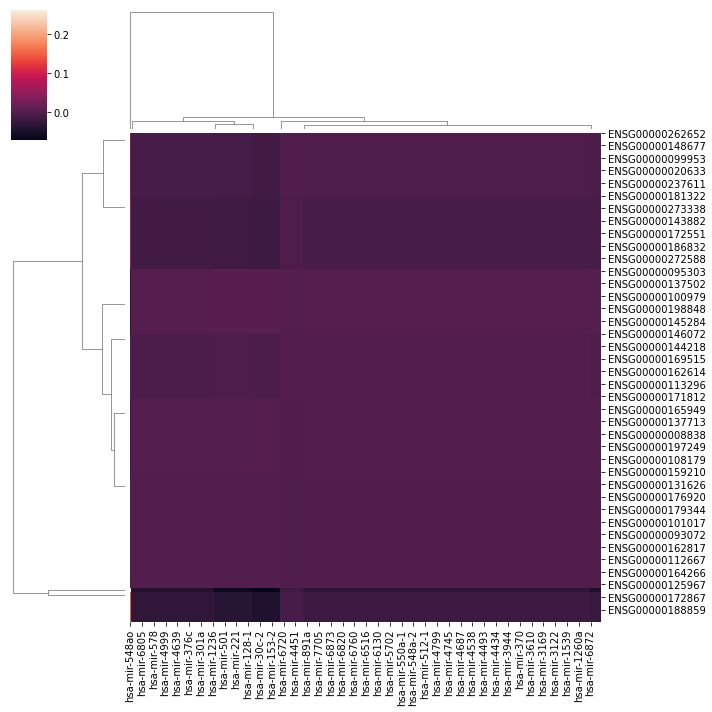

In [21]:
import seaborn as sns
cm = sns.clustermap(df_Pgk.subtract(df_Pgm.mean(1),0).divide(df_Pgm.mean(1),0).dropna(how="all", axis=1),
              )

In [17]:
for g in df_Pgk.loc[df_Pgk.index[cm.dendrogram_col.reordered_ind[:30]],:].index:
    print(g)

ENSG00000137713
ENSG00000107104
ENSG00000057663
ENSG00000079215
ENSG00000165474
ENSG00000164919
ENSG00000164850
ENSG00000164816
ENSG00000162576
ENSG00000150687
ENSG00000146677
ENSG00000146674
ENSG00000146476
ENSG00000124216
ENSG00000112096
ENSG00000111962
ENSG00000108604
ENSG00000108602
ENSG00000108551
ENSG00000106799
ENSG00000106780
ENSG00000106483
ENSG00000105639
ENSG00000105619
ENSG00000105376
ENSG00000105357
ENSG00000105171
ENSG00000104738
ENSG00000099284
ENSG00000099256


In [ ]:
for mirna in df_Pgk.loc[np.random.choice(df_Pgk.index),:].sort_values(ascending=False)[:20].items():
    print(mirna[0])

## Distinctivness

In [18]:
@tf.function
def kullbach_liebler(theta_k, theta_l):
    # dey-visualizing paper
    return tf.subtract(tf.add(tf.math.multiply(theta_k, tf.math.log(tf.math.divide(theta_k, theta_l))), theta_l),
                       theta_k)

@tf.function
def distinctivness(theta_k):
    return tf.reduce_min(tf.sort(theta_k)[:, 1:], axis=1)

@tf.function
def get_distinctivness(data):
    KL_tensor = tf.map_fn(fn=lambda k: tf.map_fn(fn=lambda l: kullbach_liebler(k, l), elems=data), elems=data, parallel_iterations=3)
    KL_tensor_min = tf.map_fn(distinctivness, tf.transpose(KL_tensor, perm=[2, 0, 1]), parallel_iterations=3)
    return KL_tensor_min

In [ ]:
out = get_distinctivness(tf.convert_to_tensor(df_Pgm.values)).numpy()
out.shape

In [ ]:
df_D = pd.DataFrame(data=out, columns=df_Pgm.index, index=df_Pgm.columns)
df_D.head(2)

In [ ]:
for g in df_D.transpose()["Metadatum 4"].sort_values(ascending=False).items():
    print(g[0])